## Import

In [12]:
!pip install segmentation-models-pytorch -q

In [13]:
import os
import random
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
from sklearn.model_selection import train_test_split
import cv2 


In [14]:
# Try importing segmentation_models_pytorch
try:
    import segmentation_models_pytorch as smp
except ImportError:
    print("Please install segmentation_models_pytorch: pip install segmentation-models-pytorch")
    exit()

## CONFIG

In [ ]:
NAME_VERSION = "unet-resnet34-v5"    
# Parameters
TRAIN_IMAGE_DIR = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images'
TRAIN_MASK_DIR = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/masks'
VAL_IMAGE_DIR = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/val/images'

OUTPUT_DIR = f'/kaggle/working/{NAME_VERSION}'

TARGET_SIZE = 512  # Higher resolution for better segmentation
BATCH_SIZE = 4     # Smaller batch size for higher resolution
NUM_EPOCHS = 40    # More epochs for better convergence
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5  # L2 regularization
USE_AMP = False     # Use mixed precision for faster training

SHRINK_MASKS = True  # Whether to apply mask shrinking
SEGMENT_GAP_SIZE = 2  # Gap size between color segments (larger = wider gaps)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Using device: {DEVICE}")

Using device: cuda


In [17]:
# Check if files exist in directories
if not os.path.exists(TRAIN_IMAGE_DIR):
    raise FileNotFoundError(f"Training image directory not found: {TRAIN_IMAGE_DIR}")
if not os.path.exists(TRAIN_MASK_DIR):
    raise FileNotFoundError(f"Training mask directory not found: {TRAIN_MASK_DIR}")
if not os.path.exists(VAL_IMAGE_DIR):
    raise FileNotFoundError(f"Validation image directory not found: {VAL_IMAGE_DIR}")

## Seed

In [18]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()


## Shrinking helper

In [19]:
# Function for advanced mask processing based on color segments
def process_color_segmented_mask(mask_path, gap_size=2):
    """
    Process a mask that has multiple color segments:
    1. Read the original colored mask
    2. Identify all outlines between different colored segments
    3. Remove these outlines (set to black)
    4. Return the processed binary mask
    
    Args:
        mask_path: Path to the mask file
        gap_size: Size of the gap to create between segments
        
    Returns:
        Processed binary mask with segment outlines removed
    """
    # Read the original mask (preserving colors if present)
    original_mask = np.array(Image.open(mask_path))
    
    # Create a blank mask for the output
    processed_mask = np.zeros(original_mask.shape[:2], dtype=np.uint8)
    
    # Handle different types of masks
    if len(original_mask.shape) == 3 and original_mask.shape[2] == 3:  # RGB mask
        # Find unique colors in the mask
        colors = np.unique(original_mask.reshape(-1, original_mask.shape[2]), axis=0)
        
        # Process each color segment
        for color in colors:
            # Skip black background
            if np.all(color == 0):
                continue
                
            # Create a binary mask for this color
            color_mask = np.all(original_mask == color.reshape(1, 1, 3), axis=2).astype(np.uint8)
            
            # Erode the mask to create gap between segments
            kernel = np.ones((gap_size, gap_size), np.uint8)
            eroded_mask = cv2.erode(color_mask, kernel, iterations=1)
            
            # Add this segment to the processed mask
            processed_mask = np.maximum(processed_mask, eroded_mask)
    
    else:  # Grayscale mask - assume it might have different gray values for segments
        # Find unique intensity values
        intensities = np.unique(original_mask)
        
        for intensity in intensities:
            # Skip black background
            if intensity == 0:
                continue
                
            # Create a binary mask for this intensity
            intensity_mask = (original_mask == intensity).astype(np.uint8)
            
            # Erode the mask to create gap between segments
            kernel = np.ones((gap_size, gap_size), np.uint8)
            eroded_mask = cv2.erode(intensity_mask, kernel, iterations=1)
            
            # Add this segment to the processed mask
            processed_mask = np.maximum(processed_mask, eroded_mask)
    
    return processed_mask.astype(np.float32)

In [20]:
# Visualization function for color segment processing
def visualize_segment_processing(original_image, original_colored_mask, processed_mask, save_path):
    """
    Visualize the effect of processing color-segmented masks
    
    Args:
        original_image: Original RGB image
        original_colored_mask: Original mask (potentially with color segments)
        processed_mask: Mask after removing segment outlines 
        save_path: Path to save the visualization
    """
    plt.figure(figsize=(15, 5))
    
    # Show original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Show original mask
    plt.subplot(1, 3, 2)
    if len(original_colored_mask.shape) == 3:
        plt.imshow(original_colored_mask)
    else:
        plt.imshow(original_colored_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')
    
    # Show processed mask
    plt.subplot(1, 3, 3)
    plt.imshow(processed_mask, cmap='gray')
    plt.title('Processed Mask (Gaps Added)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [21]:
# Function to visualize different gap sizes
def visualize_gap_sizes(original_image, mask_path, save_path):
    """
    Visualize the effect of different gap sizes on color segmented masks
    
    Args:
        original_image: Original RGB image
        mask_path: Path to the mask file
        save_path: Path to save the visualization
    """
    # Process with different gap sizes
    gap_sizes = [1, 2, 3, 4]
    processed_masks = []
    
    for gap_size in gap_sizes:
        processed_mask = process_color_segmented_mask(mask_path, gap_size=gap_size)
        processed_masks.append(processed_mask)
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 5, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Each gap size
    for i, (gap_size, processed_mask) in enumerate(zip(gap_sizes, processed_masks)):
        plt.subplot(1, 5, i + 2)
        overlay = original_image.copy()
        overlay[processed_mask > 0] = (
            overlay[processed_mask > 0] * 0.7 + 
            np.array([0, 0, 255], dtype=np.uint8) * 0.3
        )
        plt.imshow(overlay)
        plt.title(f"Gap Size = {gap_size}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

## Dataset and Transformation

In [22]:
# Dataset class for training
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, image_list=None, 
                 shrink_masks=False, gap_size=2):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.shrink_masks = shrink_masks
        self.gap_size = gap_size
        
        # Get list of image files
        if image_list is not None:
            self.images = image_list
        else:
            self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        image = np.array(Image.open(img_path).convert("RGB"))
        
        if self.mask_dir:  # Training or validation with masks
            mask_name = os.path.splitext(img_name)[0] + '.png'
            mask_path = os.path.join(self.mask_dir, mask_name)
            
            # Handle mask loading errors gracefully
            try:
                if self.shrink_masks:
                    # Process mask using color segment information
                    mask = process_color_segmented_mask(mask_path, gap_size=self.gap_size)
                else:
                    # Load mask normally if not applying processing
                    mask = np.array(Image.open(mask_path).convert("L"))  # Grayscale
                    mask = (mask > 0).astype(np.float32)
            except Exception as e:
                print(f"Error loading mask {mask_path}: {e}")
                # Create an empty mask if there's an error
                mask = np.zeros(image.shape[:2], dtype=np.float32)
            
            if self.transform:
                augmentations = self.transform(image=image, mask=mask)
                image = augmentations["image"]
                mask = augmentations["mask"]
            return image, mask
        else:  # Test set, no masks
            if self.transform:
                augmentations = self.transform(image=image)
                image = augmentations["image"]
            return image, img_name

In [23]:
# Define transformations with specific target size for blast fragments
def get_transforms(train=True, target_size=512):  # Increased size for better detail
    if train:
        return A.Compose([
            A.Resize(height=target_size, width=target_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.GaussianBlur(p=0.3),
            A.GaussNoise(p=0.2),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=target_size, width=target_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

## Utils

In [24]:
# RLE encoding function from the competition description
def mask_to_rle(mask):
    """
    Convert a binary mask to run-length encoding (RLE)
    """
    # Flatten mask
    pixels = mask.flatten()
    # Compress the mask with RLE
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    # Convert to string
    rle = ' '.join(str(x) for x in runs)
    return rle

In [25]:
# RLE decoding function for the competition
def rle_to_mask(rle, shape):
    """
    Convert RLE to mask
    """
    if rle == '' or rle is None:
        return np.zeros(shape, dtype=np.uint8)
    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1  # RLE starts from 1, convert to 0-based indexing
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [26]:
# IoU (Jaccard Index) for evaluation as per competition metric
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [27]:
# Display predictions
def display_predictions(model, dataset, device, num_samples=3, save_path='predictions.png'):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Sample indices randomly
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            pred_mask = torch.sigmoid(output) > 0.5
        
        # Convert tensors to numpy for display
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()
        pred_mask_np = pred_mask.squeeze().cpu().numpy()
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
        
        # Display
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask_np, cmap='gray')
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [28]:
# Save training history plot and metrics
def save_training_history(train_losses, val_losses, train_ious, val_ious, save_dir):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save metrics to CSV
    history = {
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_ious,
        'val_iou': val_ious
    }
    pd.DataFrame(history).to_csv(os.path.join(save_dir, 'training_history.csv'), index=False)
    
    # Plot training history
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], train_losses, 'b-', label='Training Loss')
    plt.plot(history['epoch'], val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], train_ious, 'b-', label='Training IoU')
    plt.plot(history['epoch'], val_ious, 'r-', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close()

## Train and val helper

In [29]:
# Training function with mixed precision
def train_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0
    iou_scores = []
    
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.float().to(device).unsqueeze(1)  # Add channel dimension
        
        # Use mixed precision if scaler is provided
        if scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            # Scale gradients and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate IoU score for this batch
        with torch.no_grad():
            pred_masks = torch.sigmoid(outputs)
            iou = iou_score(pred_masks, masks)
            iou_scores.append(iou.item())
    
    return epoch_loss / len(loader), np.mean(iou_scores)

In [30]:
# Validation function
def valid_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    iou_scores = []
    
    with torch.no_grad():
        for images, masks in tqdm(loader):
            images = images.to(device)
            masks = masks.float().to(device).unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            epoch_loss += loss.item()
            pred_masks = torch.sigmoid(outputs)
            iou = iou_score(pred_masks, masks)
            iou_scores.append(iou.item())
    
    return epoch_loss / len(loader), np.mean(iou_scores)

## Prediction Helpers

In [31]:
# Prediction and RLE encoding for competition submission
def predict_and_encode(model, loader, device, target_size=512):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, img_names in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            
            for pred_mask, img_name in zip(pred_masks, img_names):
                pred_mask = pred_mask.squeeze()  # Remove channel dimension
                # Convert to RLE format
                rle = mask_to_rle(pred_mask)
                image_id = os.path.splitext(img_name)[0]
                predictions.append({'id': image_id, 'rle': rle})
    
    return predictions

## Split train and val

In [32]:
# Get all images
all_images = [f for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.jpg')]
print(f"Found {len(all_images)} images in training directory")

# Verify mask files exist for training images
valid_images = []
for img_file in all_images:
    mask_file = os.path.splitext(img_file)[0] + '.png'
    if os.path.exists(os.path.join(TRAIN_MASK_DIR, mask_file)):
        valid_images.append(img_file)

if len(valid_images) < len(all_images):
    print(f"Warning: Only {len(valid_images)} of {len(all_images)} images have corresponding masks")

# Split data into train and validation
train_images, valid_images = train_test_split(
    valid_images, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(valid_images)}")

Found 768 images in training directory
Training images: 614
Validation images: 154


## Visualize Shrink

In [33]:
# Update the visualization code
if SHRINK_MASKS:
    # Create directory for mask visualizations
    mask_viz_dir = os.path.join(OUTPUT_DIR, 'mask_visualizations')
    os.makedirs(mask_viz_dir, exist_ok=True)
    
    # Select a few random samples from validation set
    for i in range(5):
        # Load image and original mask
        img_name = valid_images[i]
        img_path = os.path.join(TRAIN_IMAGE_DIR, img_name)
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(TRAIN_MASK_DIR, mask_name)
        
        # Load original image
        original_image = np.array(Image.open(img_path).convert("RGB"))
        
        # Load original mask (preserving color information if present)
        original_mask = np.array(Image.open(mask_path))
        
        # Process the mask using the color segment method
        processed_mask = process_color_segmented_mask(mask_path, gap_size=SEGMENT_GAP_SIZE)
        
        # Visualize
        visualize_segment_processing(
            original_image,
            original_mask, 
            processed_mask,
            save_path=os.path.join(mask_viz_dir, f'segment_processing_sample_{i}.png')
        )
        
        # Visualize with different gap sizes
        visualize_gap_sizes(
            original_image,
            mask_path,
            save_path=os.path.join(mask_viz_dir, f'gap_size_comparison_sample_{i}.png')
        )
    
    print(f"Mask segmentation visualizations saved to '{mask_viz_dir}'")

Mask segmentation visualizations saved to '/kaggle/working/unet-resnet34-v3.1/mask_visualizations'


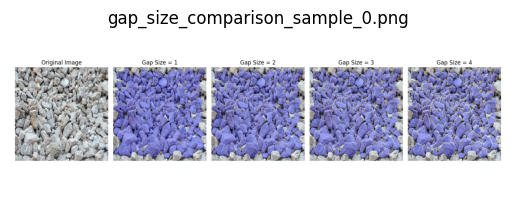

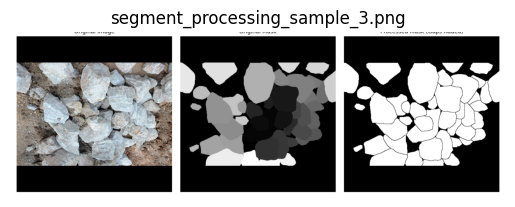

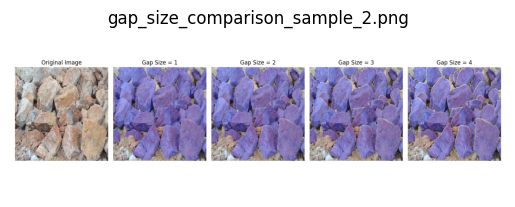

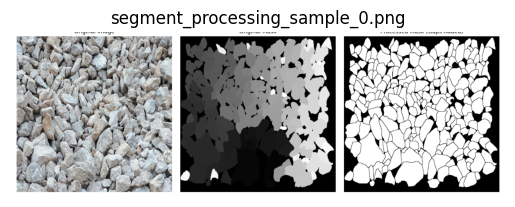

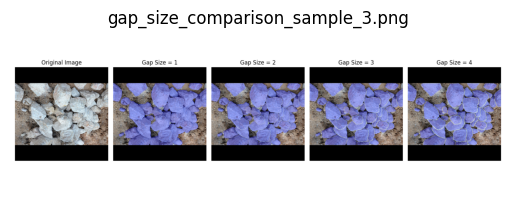

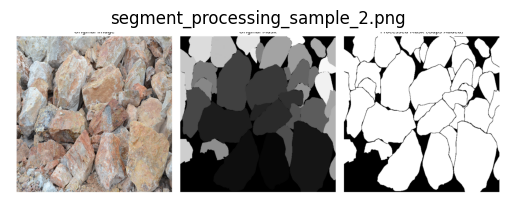

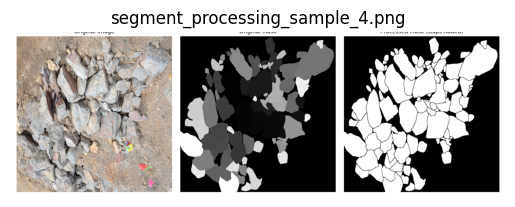

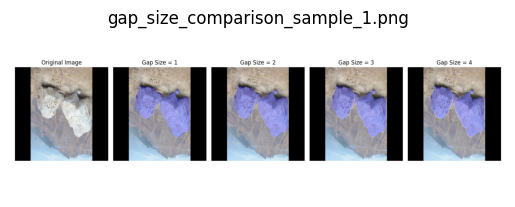

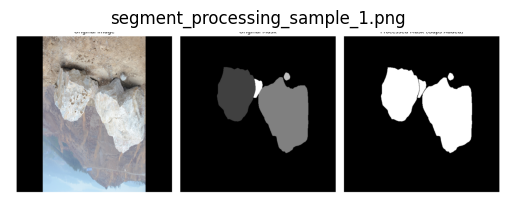

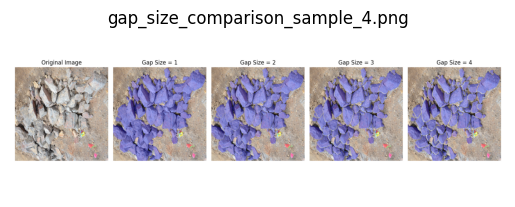

In [34]:
# Check if the folder exists
if SHRINK_MASKS:
    folder_path = mask_viz_dir
    # Get a list of files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # If there are no files in the folder
    if not image_files:
        print(f"No files found in '{folder_path}'.")
    else:
        # Display each image
        for image_file in image_files:
            try:
                # Construct the full image path
                image_path = os.path.join(folder_path, image_file)

                # Open the image using PIL (Pillow)
                img = Image.open(image_path)

                # Display the image using matplotlib
                plt.figure() # Create a new figure for each image
                plt.imshow(img)
                plt.title(image_file) # Optional: Add filename as title
                plt.axis('off')      # Optional: Turn off axis labels and ticks
                plt.show()

            except Exception as e:
                print(f"Error displaying image '{image_file}': {e}")

## DataLoader

In [35]:
# Define transformations
train_transform = get_transforms(train=True, target_size=TARGET_SIZE)
valid_transform = get_transforms(train=False, target_size=TARGET_SIZE)

# Data loaders with appropriate number of workers
num_workers = min(8, os.cpu_count() or 1)

train_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    image_list=train_images,
    shrink_masks=SHRINK_MASKS,
    gap_size=SEGMENT_GAP_SIZE
)

valid_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=valid_transform,
    image_list=valid_images,
    shrink_masks=SHRINK_MASKS,
    gap_size=SEGMENT_GAP_SIZE
)

test_dataset = SegmentationDataset(
    image_dir=VAL_IMAGE_DIR,
    mask_dir=None,
    transform=valid_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

## Model

In [36]:
# Model - try a different architecture
model = smp.UnetPlusPlus(  # UNet++ often performs better for medical-like segmentation
    encoder_name="efficientnet-b3",  # Higher capacity encoder
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 371MB/s]


## Loss/Optimizer/Scheduler/Scaler

In [37]:
# Loss function - Combined BCE and Dice loss for better boundary detection
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight  # Weight for BCE vs Dice
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        # BCE Loss
        bce_loss = self.bce(pred, target)
        
        # Dice Loss
        pred_sigmoid = torch.sigmoid(pred)
        intersection = (pred_sigmoid * target).sum()
        dice_loss = 1 - (2. * intersection + 1) / (pred_sigmoid.sum() + target.sum() + 1)
        
        # Combine losses
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

criterion = BCEDiceLoss(weight=0.7)

# Initialize mixed precision scaler
scaler = GradScaler() if USE_AMP and DEVICE.type == 'cuda' else None


# Optimizer with weight decay for regularization
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler with cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,  # Restart every 5 epochs
    T_mult=1, 
    eta_min=1e-6
)

## Traing loop

In [38]:
# Training loop
best_iou = -1
model_save_path = os.path.join(OUTPUT_DIR, "best_model.pth")

# For tracking metrics
train_losses, val_losses = [], []
train_ious, val_ious = [], []

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_iou = train_epoch(model, train_loader, optimizer, criterion, DEVICE, scaler)
    
    # Validate
    valid_loss, valid_iou = valid_epoch(model, valid_loader, criterion, DEVICE)
    
    # Update learning rate
    scheduler.step()
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_ious.append(train_iou)
    val_ious.append(valid_iou)
    
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if valid_iou > best_iou:
        best_iou = valid_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_iou': best_iou,
        }, model_save_path)
        print(f"Saved best model to {model_save_path}!")

# Calculate training time
time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best validation IoU: {best_iou:.4f}')

Epoch 1/40


100%|██████████| 39/39 [00:03<00:00, 11.05it/s]


Train Loss: 0.2902, Train IoU: 0.7648
Valid Loss: 0.1847, Valid IoU: 0.8484
Learning rate: 0.000452
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 2/40


100%|██████████| 39/39 [00:03<00:00, 10.85it/s]


Train Loss: 0.2070, Train IoU: 0.8346
Valid Loss: 0.1775, Valid IoU: 0.8481
Learning rate: 0.000328
Epoch 3/40


100%|██████████| 39/39 [00:03<00:00, 11.20it/s]


Train Loss: 0.1744, Train IoU: 0.8566
Valid Loss: 0.1472, Valid IoU: 0.8735
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 4/40


100%|██████████| 39/39 [00:03<00:00, 10.76it/s]


Train Loss: 0.1620, Train IoU: 0.8670
Valid Loss: 0.1387, Valid IoU: 0.8805
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 5/40


100%|██████████| 39/39 [00:03<00:00, 11.18it/s]


Train Loss: 0.1511, Train IoU: 0.8732
Valid Loss: 0.1303, Valid IoU: 0.8856
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 6/40


100%|██████████| 39/39 [00:03<00:00, 11.14it/s]


Train Loss: 0.1634, Train IoU: 0.8635
Valid Loss: 0.1485, Valid IoU: 0.8777
Learning rate: 0.000452
Epoch 7/40


100%|██████████| 39/39 [00:03<00:00, 11.13it/s]


Train Loss: 0.1537, Train IoU: 0.8693
Valid Loss: 0.1352, Valid IoU: 0.8824
Learning rate: 0.000328
Epoch 8/40


100%|██████████| 39/39 [00:03<00:00, 11.16it/s]


Train Loss: 0.1449, Train IoU: 0.8775
Valid Loss: 0.1242, Valid IoU: 0.8910
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 9/40


100%|██████████| 39/39 [00:03<00:00, 11.18it/s]


Train Loss: 0.1410, Train IoU: 0.8834
Valid Loss: 0.1151, Valid IoU: 0.8962
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 10/40


100%|██████████| 39/39 [00:03<00:00, 11.15it/s]


Train Loss: 0.1291, Train IoU: 0.8882
Valid Loss: 0.1104, Valid IoU: 0.8991
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 11/40


100%|██████████| 39/39 [00:04<00:00,  9.56it/s]


Train Loss: 0.1324, Train IoU: 0.8855
Valid Loss: 0.1174, Valid IoU: 0.8924
Learning rate: 0.000452
Epoch 12/40


100%|██████████| 39/39 [00:03<00:00, 11.12it/s]


Train Loss: 0.1314, Train IoU: 0.8854
Valid Loss: 0.1106, Valid IoU: 0.8972
Learning rate: 0.000328
Epoch 13/40


100%|██████████| 39/39 [00:03<00:00, 11.02it/s]


Train Loss: 0.1235, Train IoU: 0.8922
Valid Loss: 0.1043, Valid IoU: 0.9039
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 14/40


100%|██████████| 39/39 [00:03<00:00, 11.22it/s]


Train Loss: 0.1175, Train IoU: 0.8966
Valid Loss: 0.1028, Valid IoU: 0.9068
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 15/40


100%|██████████| 39/39 [00:03<00:00, 10.99it/s]


Train Loss: 0.1129, Train IoU: 0.9008
Valid Loss: 0.0992, Valid IoU: 0.9088
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 16/40


100%|██████████| 39/39 [00:03<00:00, 11.11it/s]


Train Loss: 0.1315, Train IoU: 0.8866
Valid Loss: 0.1678, Valid IoU: 0.8587
Learning rate: 0.000452
Epoch 17/40


100%|██████████| 39/39 [00:03<00:00, 11.07it/s]


Train Loss: 0.1351, Train IoU: 0.8832
Valid Loss: 0.1088, Valid IoU: 0.9014
Learning rate: 0.000328
Epoch 18/40


100%|██████████| 39/39 [00:03<00:00, 11.13it/s]


Train Loss: 0.1308, Train IoU: 0.8869
Valid Loss: 0.1014, Valid IoU: 0.9067
Learning rate: 0.000173
Epoch 19/40


100%|██████████| 39/39 [00:03<00:00,  9.78it/s]


Train Loss: 0.1143, Train IoU: 0.8987
Valid Loss: 0.0947, Valid IoU: 0.9122
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 20/40


100%|██████████| 39/39 [00:03<00:00, 11.11it/s]


Train Loss: 0.1097, Train IoU: 0.9027
Valid Loss: 0.0943, Valid IoU: 0.9129
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 21/40


100%|██████████| 39/39 [00:03<00:00, 11.08it/s]


Train Loss: 0.1160, Train IoU: 0.8985
Valid Loss: 0.0994, Valid IoU: 0.9090
Learning rate: 0.000452
Epoch 22/40


100%|██████████| 39/39 [00:03<00:00, 10.35it/s]


Train Loss: 0.1154, Train IoU: 0.8982
Valid Loss: 0.0978, Valid IoU: 0.9101
Learning rate: 0.000328
Epoch 23/40


100%|██████████| 39/39 [00:03<00:00, 11.17it/s]


Train Loss: 0.1091, Train IoU: 0.9036
Valid Loss: 0.0928, Valid IoU: 0.9154
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 24/40


100%|██████████| 39/39 [00:03<00:00, 11.26it/s]


Train Loss: 0.1037, Train IoU: 0.9079
Valid Loss: 0.0895, Valid IoU: 0.9175
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 25/40


100%|██████████| 39/39 [00:03<00:00, 10.97it/s]


Train Loss: 0.1010, Train IoU: 0.9098
Valid Loss: 0.0884, Valid IoU: 0.9180
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 26/40


100%|██████████| 39/39 [00:03<00:00, 11.14it/s]


Train Loss: 0.1068, Train IoU: 0.9052
Valid Loss: 0.0924, Valid IoU: 0.9155
Learning rate: 0.000452
Epoch 27/40


100%|██████████| 39/39 [00:03<00:00, 11.10it/s]


Train Loss: 0.1081, Train IoU: 0.9047
Valid Loss: 0.0921, Valid IoU: 0.9135
Learning rate: 0.000328
Epoch 28/40


100%|██████████| 39/39 [00:03<00:00, 11.11it/s]


Train Loss: 0.1013, Train IoU: 0.9096
Valid Loss: 0.0867, Valid IoU: 0.9197
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 29/40


100%|██████████| 39/39 [00:03<00:00, 10.17it/s]


Train Loss: 0.0998, Train IoU: 0.9115
Valid Loss: 0.0877, Valid IoU: 0.9202
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 30/40


100%|██████████| 39/39 [00:03<00:00, 10.92it/s]


Train Loss: 0.0956, Train IoU: 0.9148
Valid Loss: 0.0823, Valid IoU: 0.9235
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 31/40


100%|██████████| 39/39 [00:03<00:00, 11.04it/s]


Train Loss: 0.1022, Train IoU: 0.9094
Valid Loss: 0.0899, Valid IoU: 0.9174
Learning rate: 0.000452
Epoch 32/40


100%|██████████| 39/39 [00:03<00:00, 11.08it/s]


Train Loss: 0.1008, Train IoU: 0.9103
Valid Loss: 0.0868, Valid IoU: 0.9191
Learning rate: 0.000328
Epoch 33/40


100%|██████████| 39/39 [00:03<00:00, 11.03it/s]


Train Loss: 0.0972, Train IoU: 0.9137
Valid Loss: 0.0835, Valid IoU: 0.9224
Learning rate: 0.000173
Epoch 34/40


100%|██████████| 39/39 [00:03<00:00, 11.12it/s]


Train Loss: 0.0939, Train IoU: 0.9162
Valid Loss: 0.0806, Valid IoU: 0.9242
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 35/40


100%|██████████| 39/39 [00:03<00:00, 11.10it/s]


Train Loss: 0.0920, Train IoU: 0.9176
Valid Loss: 0.0803, Valid IoU: 0.9246
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Epoch 36/40


100%|██████████| 39/39 [00:03<00:00, 11.14it/s]


Train Loss: 0.0974, Train IoU: 0.9132
Valid Loss: 0.0881, Valid IoU: 0.9202
Learning rate: 0.000452
Epoch 37/40


100%|██████████| 39/39 [00:03<00:00, 11.12it/s]


Train Loss: 0.0990, Train IoU: 0.9119
Valid Loss: 0.0926, Valid IoU: 0.9193
Learning rate: 0.000328
Epoch 38/40


100%|██████████| 39/39 [00:03<00:00, 11.06it/s]


Train Loss: 0.1273, Train IoU: 0.8932
Valid Loss: 0.0848, Valid IoU: 0.9224
Learning rate: 0.000173
Epoch 39/40


100%|██████████| 39/39 [00:03<00:00, 10.95it/s]


Train Loss: 0.0965, Train IoU: 0.9143
Valid Loss: 0.0820, Valid IoU: 0.9237
Learning rate: 0.000049
Epoch 40/40


100%|██████████| 39/39 [00:03<00:00, 10.42it/s]


Train Loss: 0.0933, Train IoU: 0.9166
Valid Loss: 0.0798, Valid IoU: 0.9259
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3.1/best_model.pth!
Training complete in 36m 27s
Best validation IoU: 0.9259


## Save

In [39]:
# Save training history
save_training_history(train_losses, val_losses, train_ious, val_ious, OUTPUT_DIR)

# Load best model for evaluation and prediction
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Validate with best model
valid_loss, valid_iou = valid_epoch(model, valid_loader, criterion, DEVICE)
print(f"Best model - Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}")

# Save visualizations of predictions
display_predictions(
    model, 
    valid_dataset, 
    DEVICE, 
    num_samples=5, 
    save_path=os.path.join(OUTPUT_DIR, 'predictions.png')
)
print(f"Predictions visualization saved to '{os.path.join(OUTPUT_DIR, 'predictions.png')}'")

<ipython-input-39-11cae5e55e3a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_save_path)
100%|██████████| 39/39 [00:03<00:00, 10.98it/s]


Best model - Valid Loss: 0.0798, Valid IoU: 0.9259
Predictions visualization saved to '/kaggle/working/unet-resnet34-v3.1/predictions.png'


## Infer

In [40]:
# Generate predictions for test set and save in RLE format
test_predictions = predict_and_encode(model, test_loader, DEVICE, target_size=TARGET_SIZE)
submission_df = pd.DataFrame(test_predictions)
submission_path = os.path.join(OUTPUT_DIR, 'submission.csv')
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to '{submission_path}'")

100%|██████████| 48/48 [00:04<00:00, 11.18it/s]

Submission file saved to '/kaggle/working/unet-resnet34-v3.1/submission.csv'
